In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
#
import warnings
warnings.filterwarnings('ignore')
#
from tensorflow.keras.applications import DenseNet121,ResNet50
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
# 
print(tf.__version__)

2.10.0


## Reproducibilty

In [2]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

## Data Augmentaion

In [39]:
TRAIN_DIR = "Anomaly Photos/"
TEST_DIR = "Test/"

In [4]:
image_size =(64,64)
batch_size = 64
INPUT_SHAPE=(64,64,3)

#### Define Train Test and Validation Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [6]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    subset='training',
    class_mode='categorical',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 180066 images belonging to 7 classes.


In [7]:
 
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    class_mode='categorical',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)



Found 45014 images belonging to 7 classes.


In [40]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    class_mode=None,
    target_size=image_size,
    batch_size=1,
    shuffle=False
)

Found 28743 images belonging to 1 classes.


In [ ]:
y_val = valid_generator.labels

## F1 Score Evaluation metrics

In [8]:
import tensorflow.keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Callbacks

In [9]:
folderpath = "Model/"
filepath = folderpath + "epoch_ufc:{epoch:02d}-val_loss:{val_loss:.2f}.hdf5"

In [10]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1,mode='auto', min_lr=1e-5, verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto'),
      tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)]

## Transfer Learning

In [11]:
def transfer_learning():
    base_model=ResNet50(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")
    
    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False
    
    for layers in base_model.layers[thr:]:
        layers.trainable=True
    
    return base_model

In [15]:
def create_model():
    model=Sequential()
    
    base_model=transfer_learning()
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation="relu"))
    
    model.add(Dense(7,activation="softmax",name="classification"))
    
    model.summary()
    
    return model
    

In [16]:
model=create_model()
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy',get_f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

In [21]:
history = model.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = val_generator.n//val_generator.batch_size,
                    epochs=5)

Epoch 1/5
2813/2813 [==============================] - 1891s 672ms/step - loss: 0.8877 - accuracy: 0.6963 - get_f1: 0.6818 - val_loss: 1.3639 - val_accuracy: 0.5098 - val_get_f1: 0.4061
Epoch 2/5
2813/2813 [==============================] - 1862s 662ms/step - loss: 0.6985 - accuracy: 0.7656 - get_f1: 0.7611 - val_loss: 1.3048 - val_accuracy: 0.6106 - val_get_f1: 0.6155
Epoch 3/5
2813/2813 [==============================] - 1863s 662ms/step - loss: 0.5561 - accuracy: 0.8169 - get_f1: 0.8172 - val_loss: 1.0385 - val_accuracy: 0.6476 - val_get_f1: 0.6392
Epoch 4/5
2813/2813 [==============================] - 1864s 663ms/step - loss: 0.4409 - accuracy: 0.8579 - get_f1: 0.8594 - val_loss: 1.4106 - val_accuracy: 0.6158 - val_get_f1: 0.6194
Epoch 5/5
2813/2813 [==============================] - 1900s 675ms/step - loss: 0.3598 - accuracy: 0.8850 - get_f1: 0.8868 - val_loss: 0.9887 - val_accuracy: 0.6416 - val_get_f1: 0.6448


## Evaluate Model

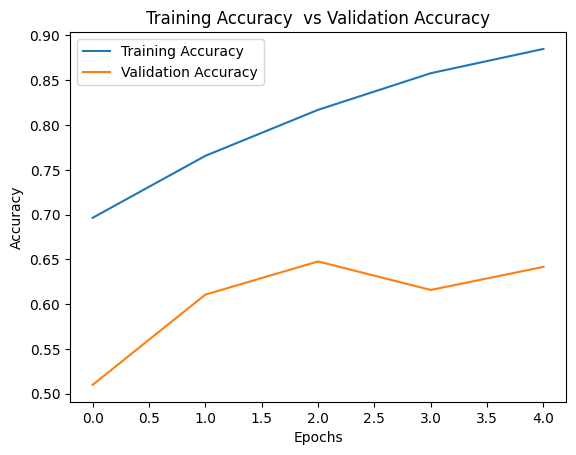

In [25]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.title('Training Accuracy  vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

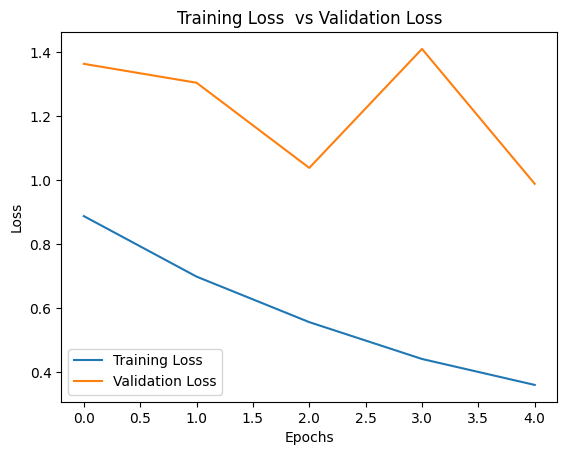

In [31]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.title('Training Loss  vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [28]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [32]:
model = tf.keras.models.load_model('model',custom_objects={'get_f1':get_f1})

In [35]:
preds = model.predict(val_generator)
predictions = np.argmax(preds,axis=1)

 39/704 [>.............................] - ETA: 4:35

KeyboardInterrupt: 

In [ ]:
print(val_generator.class_indices)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_val,predictions),
            cmap="YlGnBu",
            annot=True,
            fmt=".2f")
plt.show()

## Make inference on the test dataMake inference on the test data

In [41]:
test_data_predictions  = model.predict(test_generator)
test_predictions = np.argmax(test_data_predictions,axis=1)
file_names = test_generator.filenames

28743/28743 [==============================] - 499s 17ms/step


In [61]:
predictions = pd.DataFrame({'filenames':file_names, 'prediction':test_predictions})
actual = pd.read_csv("testing_46356.csv",names=['filenames','actuals'],skiprows=1)

In [78]:
predictions['filenames'] = predictions.filenames.astype('string').apply(lambda x:x.split('\\')[1])
predictions.head()

,filenames,prediction
0,10000_9830.png,1
1,10001_9400.png,1
2,10002_9060.png,1
3,10003_9870.png,1
4,10004_7930.png,3


In [64]:
actual.head()

,filenames,actuals
0,1_980.png,attack
1,2_1240.png,attack
2,3_1010.png,attack
3,4_1050.png,attack
4,5_550.png,attack


In [56]:
# removing "NormalVideos" images
for row in actual[actual['actuals']=='NormalVideos'].iterrows():
    if os.path.exists(f"Test/Testing/{row[1]['filenames']}"):    
        os.remove(f"Test/Testing/{row[1]['filenames']}")

In [87]:
originals = ['Abuse','Assault','Fighting','Burglary','Stealing','Shoplifting','Robbery','Explosion','RoadAccidents','Shooting',
             'Arrest','Vandalism','Arson']
finals = ['attack','attack','attack','theft','theft','theft','theft','blast','road accident','firing','arrest','deliberate damage',
         'deliberate damage']
actual['actuals'].replace(originals, finals,inplace=True)

In [94]:
merged = pd.merge(predictions,actual,on='filenames')
merged.head()

,filenames,prediction,actuals
0,10000_9830.png,1,theft
1,10001_9400.png,1,theft
2,10002_9060.png,1,theft
3,10003_9870.png,1,theft
4,10004_7930.png,3,theft


In [89]:
labels = merged.actuals.unique()
labels.sort()
labels

array(['arrest', 'attack', 'blast', 'deliberate damage', 'firing',
       'road accident', 'theft'], dtype=object)

In [93]:
labels.searchsorted('blast')

2

In [98]:
merged['actuals'] = labels.searchsorted(merged.actuals)

In [99]:
merged.head()

,filenames,prediction,actuals
0,10000_9830.png,1,6
1,10001_9400.png,1,6
2,10002_9060.png,1,6
3,10003_9870.png,1,6
4,10004_7930.png,3,6


In [106]:
from sklearn.metrics import f1_score
f1_score(merged['actuals'],merged['prediction'],average='micro')

0.42956545941620566

## Prepare Submission File

In [ ]:
import pandas as pd
df_submission = pd.DataFrame({"filename":file_names,"predictions":test_predictions})
df_submission.head()